# Hough transform cont'd
Redo the hough transform exercise, but this time with tracking the uncertainty of your estimates.

Please build the hough transform yourselves and do not use pre-build functions (albeit you can let inspire yourself).

Try your method without a filter in preprocessing and a linear filter (for edges). You may reduce the resolution of your test images for performance issues.

Build the accumulator array and plot the hypothesis for lines in the accumulator space. Calculate the covariance matrix as described in QI and Harralick.

Threshold over the accumulator space and plot the number of lines and number of found maxima. Choose a threshold so that it fits our needs. Our needs are: Remove as much background as possible, Quantify a false positive rate. You can use the annotated images or simulated images to verify your hypothesis.

A code example by Tim Frommknecht and Pedro Alves Zipf is attached. The video supporting the example will be brought to by Discord.

Are the values used in the accumulator array the best statistic to set the false positive rate for your system?

Deliverables: A jupyter/pluto notebook.

# Imports

In [1]:
import os
import re
from math import ceil
import cv2

from PIL import ImageOps

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams['figure.dpi'] = 100

from scipy.stats.mvn import mvnun

# Load Data
I imported a dataset of rails, and one simulated image of straight rails.

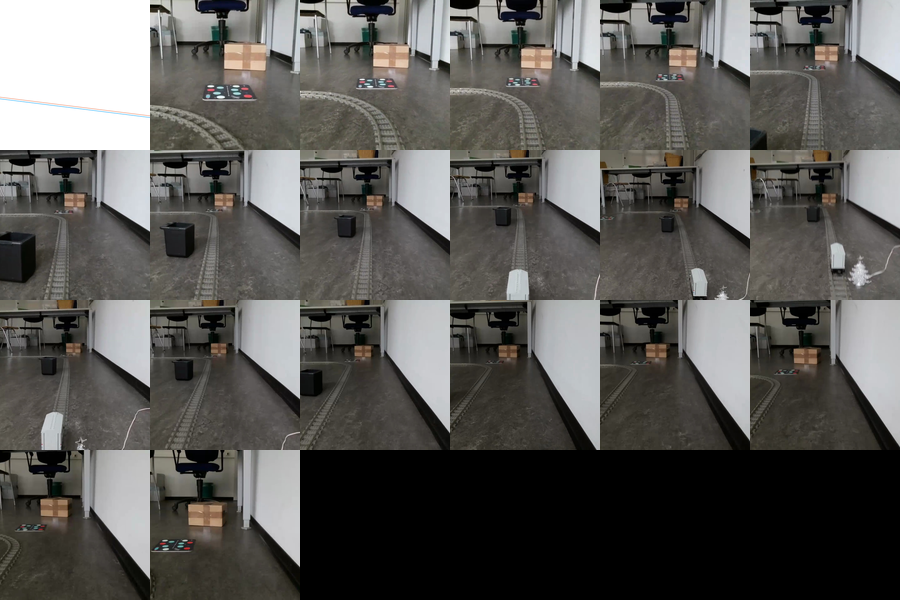

In [2]:
data_path = "test_data"

# Adapted from https://gist.github.com/njanakiev/1932e0a450df6d121c05069d5f7d7d6f

def concat_images(image_paths, size, columns=None):
    # Open images and resize them
    width, height = size
    images = map(Image.open, image_paths)
    images = [ImageOps.fit(image, size, Image.ANTIALIAS) 
              for image in images]
    
    # Create canvas for the final image with total size
    columns = columns if columns else len(image_paths)
    rows = ceil(len(image_paths)/columns) # round up
    shape = (rows, columns)
    image_size = (width * shape[1], height * shape[0])
    image = Image.new('RGB', image_size)
    
    # Paste images into final image
    for row in range(shape[0]):
        for col in range(shape[1]):
            offset = width * col, height * row
            idx = row * shape[1] + col
            if idx <= (len(image_paths)-1):
                image.paste(images[idx], offset)
            else:
                pass    
    return image


# Get list of image paths
image_paths = [os.path.join(data_path, f) 
               for f in os.listdir(data_path) if f.endswith('.jpg')]


# Create ordered frame grid
ordered_image_paths = image_paths[:] # copy path list
ordered_image_paths.sort(key = lambda x: int(re.split('frame_|.j',x)[1])) # split after "frame_" and ".j", select frame number


output_folder = 'hough/'

#if not os.path.exists(output_folder):
#    os.mkdir(output_folder)
#    os.mkdir((output_folder+"lines/"))
#    os.mkdir((output_folder+"curves/"))

ordered_grid = concat_images(ordered_image_paths, (150, 150), 6)
display(ordered_grid)

# Hough Transform with Uncertainties
Hough transform implementation by Tim Frommknecht and Pedro Alves Zipf.

In [3]:
class Hough_Transform(nn.Module):
    """
    performs hough transform on input images.
    returns the accumulated hough space
    Parameters:
        input_dim : dimensions of input image
        output_dim : size of hough space. Determines bin size for voting.
        h_plane, w_plane : dimensions of area to fit plane around each pixel
        thr_var : Threshold for variance. Each vote surpassing the threshold is considered insane and denied voting
    """
    
    def __init__(self,
                 input_dim=(64, 64),
                 output_dim=(100, 100),
                 h_plane=3,
                 w_plane=3,
                 thr_var=100):

        self.input_dim = input_dim
        self.H = input_dim[0]
        self.W = input_dim[1]
        self.output_dim = output_dim
        self.h_plane = h_plane
        self.w_plane = w_plane
        self.thr_var = thr_var


    def forward(self, img, visualize = False):
        
        alpha, beta, gamma, var_alpha, var_beta, covar_alpha_beta, noise_var = self.approximate_plane(img)

        theta, rho, cov_matrix = self.approximate_polar_coordinates(img, alpha, beta, var_alpha, var_beta,
                                                                    covar_alpha_beta)

        acc_space = self.voting(theta, rho, cov_matrix)

        if visualize:
            plot_hist(cov_matrix[:, :, 0, 0], title="variance of theta")
            plot_hist(cov_matrix[:, :, 1, 1], title="variance of rho")
            plot_hist(cov_matrix[:, :, 0, 1], clip_val=500, clip_hist=100, title="covariance")
            self.plot_variance_images(cov_matrix)
            acc_space.plot_values()

            # not working yet:
            # plot_hist(acc_space.values, clip_hist=20000, title="Histopgram Hough Space")
            # acc_space.get_n_maxima_plot(steps=50, r=1)


        return acc_space, noise_var

    def plot_variance_images(self, cov_matrix):
        var_theta_clipped = torch.clamp(cov_matrix[:, :, 0, 0], max=5)
        var_rho_clipped = torch.clamp(cov_matrix[:, :, 1, 1], max=600)
        covar_theta_rho_clipped = torch.clamp(torch.abs(cov_matrix[:, :, 0, 1]), max=100)
        plt.imshow(var_theta_clipped, cmap="gray")  # var theta
        plt.title("Variance Theta")
        plt.show()
        plt.imshow(var_rho_clipped, cmap="gray")  # var rho
        plt.title("Variance Rho")
        plt.show()
        plt.imshow(covar_theta_rho_clipped, cmap="gray")  # covar theta rho
        plt.title("Covariance Theta and Rho")
        plt.show()


    def approximate_plane(self, img):
        """
        approximates gradient for  each position of an array by a plane. dimensions of the plane are given by
        self.h_plane, self.w_plane
        :param img: source image
        :return: alpha: array of slopes of planes in x-direction
        :return: beta: array of slopes of planes in y-direction
        :return: var_alpha: array of variances of alpha (uncertainty)
        :return: var_beta:  array of variances of beta (uncertainty)
        :return: covar_alpha_beta: array of covariances of alpha and beta (joint uncertainty)
        """
        alpha = np.zeros(img.shape)
        beta = np.zeros(img.shape)
        gamma = np.zeros(img.shape)

        sum_x_squared = np.zeros(img.shape)
        sum_y_squared = np.zeros(img.shape)
        sum_xy = np.zeros(img.shape)

        delta_xi_min = - (self.h_plane // 2)  # -1
        delta_xi_max = (self.h_plane // 2) + 1  # 2
        delta_yi_min = - (self.w_plane // 2)  # -1
        delta_yi_max = (self.w_plane // 2) + 1  # 2

        for hi in range(self.H):
            for wi in range(self.W):
                for delta_x in range(delta_xi_min, delta_xi_max):  # deltax: local position {-1, 0, 1}
                    xi = max(min(hi + delta_x, self.H - 1), 0)  # xi: global position e.g. {19, 20, 21}
                    for delta_y in range(delta_yi_min, delta_yi_max):
                        yi = max(min(wi + delta_y, self.W - 1), 0)
                        alpha[hi, wi] += delta_x * img[xi, yi]
                        sum_x_squared[hi, wi] += delta_x ** 2
                        beta[hi, wi] += delta_y * img[xi, yi]
                        sum_y_squared[hi, wi] += delta_y ** 2
                        gamma[hi, wi] += img[xi, yi]
                        sum_xy[hi, wi] += delta_x * delta_y

        alpha = alpha / sum_x_squared + 0.000001  # adding a small epsilon to prevent dividing by zero
        beta = beta / sum_y_squared + 0.000001
        gamma = gamma / (self.h_plane * self.w_plane)

        """
        Additionally estimates the uncertainty of the approximated plane by calculating variances for the parameters
        """

        local_noise_var = np.zeros(img.shape)  # first calculate local var for each position
        epsilon_squared = np.zeros(img.shape)  # required to get variance

        for hi in range(self.H):
            for wi in range(self.W):
                for delta_x in range(delta_xi_min, delta_xi_max):  # deltax: local position {-1, 0, 1}
                    xi = max(min(hi + delta_x, self.H - 1), 0)  # xi: global position e.g. {19, 20, 21}
                    for delta_y in range(delta_yi_min, delta_yi_max):
                        yi = max(min(wi + delta_y, self.W - 1), 0)
                        epsilon_squared[hi, wi] += (img[xi, wi] - alpha[xi, yi] * delta_x - beta[xi, yi] * delta_y -
                                                    gamma[xi, yi]) ** 2

        local_noise_var = epsilon_squared / (self.h_plane * self.w_plane - 2)
        noise_var = np.sum(local_noise_var, axis=(0, 1)) / (self.H * self.W)

        var_alpha = noise_var / sum_x_squared
        var_beta = noise_var / sum_y_squared
        covar_alpha_beta = noise_var * sum_xy / (sum_x_squared * sum_y_squared)

        return alpha, beta, gamma, var_alpha, var_beta, covar_alpha_beta, noise_var

    def approximate_polar_coordinates(self, img, alpha, beta, var_alpha, var_beta, covar_alpha_beta):
        """
        given an approximated plane for each position in an image and given uncertainty, approximates the polar
        coordinates for the line best representing each pixels gradient. Furthermore estimates the uncertainty of the
        resulting parameters.
        All used arrays share the images dimensions
        :param img: source image
        :param alpha: array of slopes of planes in x-direction
        :param beta: array of slopes of planes in y-direction
        :param var_alpha: array of variances of alpha (uncertainty)
        :param var_beta:  array of variances of beta (uncertainty)
        :param covar_alpha_beta: array of covariances of alpha and beta (joint uncertainty)
        :return: theta: array of polar angles theta of the most likely lines
        :return: rho: array of distances of the lines to origin
        :return: cov_matrix: array of the respective covariance matricies. Holds a matrix for each pixel
        """
        theta = np.arctan(alpha / beta)
        rho = np.zeros(img.shape)
        for hi in range(self.H):
            for wi in range(self.W):
                rho[hi, wi] = wi * np.cos(theta[hi, wi]) + hi * np.sin(theta[hi, wi])

        k = np.zeros(img.shape)
        for hi in range(self.H):
            for wi in range(self.W):
                k[hi, wi] = wi * np.cos(theta[hi, wi]) - hi * np.sin(theta[hi, wi])

        var_p = 0  # made up value, replace with something reasonable

        var_theta = (var_alpha / (beta ** 2) + (alpha ** 2) * (var_beta / (beta ** 4)) - 2 * (
                    alpha / (beta ** 3)) * covar_alpha_beta) * np.cos(theta) ** 4
        var_rho = k ** 2 * var_theta + var_p
        covar_theta_rho = k * var_theta

        # fusing them into the covariance matrix
        cov_matrix = torch.zeros((self.H, self.W, 2, 2))
        cov_matrix[:, :, 0, 0] = torch.Tensor(var_theta)
        cov_matrix[:, :, 0, 1] = torch.Tensor(covar_theta_rho)
        cov_matrix[:, :, 1, 0] = torch.Tensor(covar_theta_rho)
        cov_matrix[:, :, 1, 1] = torch.Tensor(var_rho)

        return theta, rho, cov_matrix

    def voting(self, theta, rho, cov_matrix):
        # dropping votes with absurdly high uncertainty, as they would break the voting system while contributing
        # margin values
        var_theta = cov_matrix[:, :, 0, 0]
        var_rho = cov_matrix[:, :, 1, 1]
        sane_votes = (var_theta <= self.thr_var) * (var_rho <= self.thr_var)

        # Setting up hough space:
        acc_space = AccumulationSpace(self.output_dim, theta[sane_votes], rho[sane_votes],
                                      var_theta[sane_votes], var_rho[sane_votes])

        """
        Bayesian Voting: Each pixel of the image with sane variances gives a vote. 
        Each vote is shaped gaussian with the given uncertainty (cov_matrix).
        The vote for each bin is calculated by integrating the gaussian over the bin
        All votes are added up in the accumulated hough space (acc_space)
        """

        # creating a vector containing theta and rho for each element (makes code below look more clean)
        mean_vector = torch.Tensor(np.concatenate((np.expand_dims(theta, axis=2), np.expand_dims(rho, axis=2)), axis=2))

        # TODO: Performance!
        for hi in range(self.H):
            for wi in range(self.W):
                if sane_votes[hi, wi]:
                    # getting boundaries for a three sigma radius to only vote for relevant positions (performance)
                    theta_interval = 3 * acc_space.theta_std  # 99% confidence interval
                    rho_interval = 3 * acc_space.rho_std  # 99% confidence interval
                    theta_lower_bound = max(min(theta[hi,wi] - theta_interval, acc_space.theta_max), acc_space.theta_min)
                    theta_upper_bound = max(min(theta[hi,wi] + theta_interval, acc_space.theta_max), acc_space.theta_min)
                    theta_lower_i = acc_space.get_index_theta(theta_lower_bound)
                    theta_upper_i = acc_space.get_index_theta(theta_upper_bound)
                    rho_lower_bound = max(min(rho[hi,wi] - rho_interval, acc_space.rho_max), acc_space.rho_min)
                    rho_upper_bound = max(min(rho[hi,wi] + rho_interval, acc_space.rho_max), acc_space.rho_min)
                    rho_lower_i = acc_space.get_index_rho(rho_lower_bound)
                    rho_upper_i = acc_space.get_index_rho(rho_upper_bound)

                    theta_ix = np.arange(theta_lower_i, theta_upper_i)
                    rho_ix = np.arange(rho_lower_i, rho_upper_i)
                    """
                    theta_value = acc_space.get_value_theta(theta_ix)
                    rho_value = acc_space.get_value_rho(rho_ix)
                    theta_bin_lower = theta_value - 0.5 * acc_space.theta_binsize
                    theta_bin_upper = theta_value + 0.5 * acc_space.theta_binsize
                    rho_bin_lower = rho_value - 0.5 * acc_space.rho_binsize
                    rho_bin_upper = rho_value + 0.5 * acc_space.rho_binsize
                    """
                    for theta_i in range(theta_lower_i, theta_upper_i):
                        for rho_i in range(rho_lower_i, rho_upper_i):

                            theta_value = acc_space.get_value_theta(theta_i)
                            rho_value = acc_space.get_value_rho(rho_i)
                            theta_bin_lower = theta_value - 0.5 * acc_space.theta_binsize
                            theta_bin_upper = theta_value + 0.5 * acc_space.theta_binsize
                            rho_bin_lower = rho_value - 0.5 * acc_space.rho_binsize
                            rho_bin_upper = rho_value + 0.5 * acc_space.rho_binsize

                            vote = mvnun(np.array([theta_bin_lower, rho_bin_lower]),
                                         np.array([theta_bin_upper, rho_bin_upper]),
                                         mean_vector[hi, wi], cov_matrix[hi, wi])[0]
                            acc_space.values[theta_i, rho_i] += vote

        return acc_space

class AccumulationSpace():
    def __init__(self, dims, theta, rho, var_theta, var_rho,
                 theta_min=None,
                 theta_max=None,
                 rho_min=None,
                 rho_max=None):
        self.dims = dims
        self.votes = np.zeros(dims)
        # defining ranges and stepsizes for accumulation space
        # Todo implement uniform ranges to make different instances comparable
        self.theta_std = np.average(np.sqrt(var_theta))
        self.rho_std = np.average(np.sqrt(var_rho))
        if theta_min is None:
            self.theta_min = np.min(theta) - self.theta_std
        else:
            self.theta_min = theta_min
        if theta_max is None:
            self.theta_max = np.max(theta) + self.theta_std
        else:
            self.theta_max = theta_max
        if rho_min is None:
            self.rho_min = np.min(rho) - self.rho_std
        else:
            self.rho_min = rho_min
        if rho_max is None:
            self.rho_max = np.max(rho) + self.rho_std
        else:
            self.rho_max = rho_max

        self.theta_binsize = (self.theta_max - self.theta_min) / dims[0]
        self.rho_binsize = (self.rho_max - self.rho_min) / dims[1]

        self.values = torch.zeros(dims)

    def get_index_theta(self, value, round = "floor"):
        if round == "floor":
            return int(np.floor((value - self.theta_min) / self.theta_binsize))
        if round == "ceil":
            return int(np.ceil((value - self.theta_min) / self.theta_binsize))

    def get_value_theta(self, index):
        return index * self.theta_binsize + self.theta_min

    def get_index_rho(self, value, round = "floor"):
        if round == "floor":
            return int(np.floor((value - self.rho_min) / self.rho_binsize))
        if round == "ceil":
            return int(np.ceil((value - self.rho_min) / self.rho_binsize))

    def get_value_rho(self, index):
        return index * self.rho_binsize + self.rho_min

    def get_hist(self):
        return torch.histc(self.values)

    def plot_hist(self):
        hist = self.get_hist()
        plt.bar(range(len(hist)), hist)
        plt.show()

    def plot_values(self):
        plt.imshow(self.values)
        plt.show()


def plot_hist(values, clip_val=255, clip_hist=300, title="histogram"):
    values = torch.clamp(values, min=-clip_val, max=clip_val)
    hist = torch.histc(values, bins=100)
    hist = torch.clamp(hist, max=clip_hist)
    plt.bar(torch.linspace(start=torch.min(values), end=torch.max(values), steps=100), hist)
    plt.title(title)
    plt.show()

In [ ]:
""" under construction
def get_local_maxima(self, r=10):
    """
    #:param r: radius to check for local maxima
    #:return: returns list of indices for all local maxima
    """
    indices_loc_max = []
    for theta_i in range(self.dims[0]):
        for rho_i in range(self.dims[1]):
            max_near_val = torch.max(self.values[max(0, theta_i - r): min(self.dims[0] - 1, theta_i + r + 1),
                                     max(0, rho_i - r): min(self.dims[1] - 1, rho_i + r + 1)])
            #print(acc_space[theta_lines[i], rho_lines[i]], max_near_val)
            if self.values[theta_i, rho_i] >= max_near_val and self.values[theta_i, rho_i] > 0:
                indices_loc_max.append(())
    return indices_loc_max
    
def get_n_maxima_plot(self, steps = 50, r=10):
    min_vote = torch.min(self.values)
    max_vote = torch.min(self.values)
    inddices_loc_max = self.get_local_maxima(r=r)
    thr_list = torch.linspace(min_vote, max_vote, steps)
    n_maxima = torch.zeros(steps)
    for i, thr in enumerate(thr_list):
        for pos in inddices_loc_max:
            if self.values[pos] >= thr:
                n_maxima[i] += 1
    plt.plot(thr_list, n_maxima)
    plt.show()
"""

Simulated Image:
(400, 600)


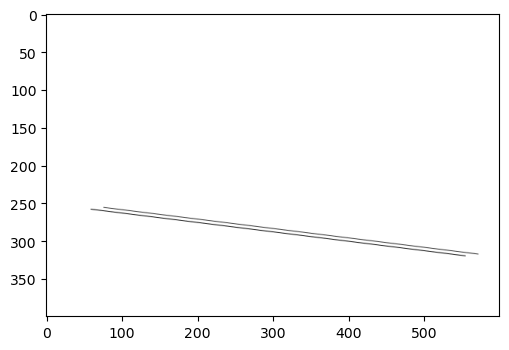

Simulated Image with Gaussian Noise:
(400, 600)


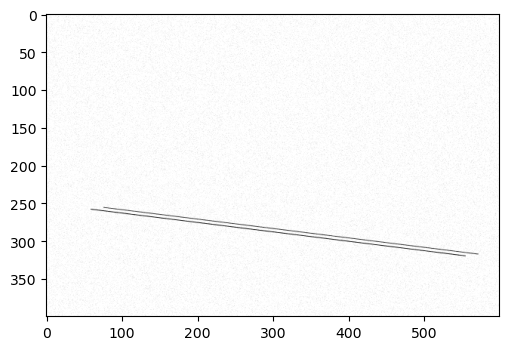

Drone Image:
(360, 480)


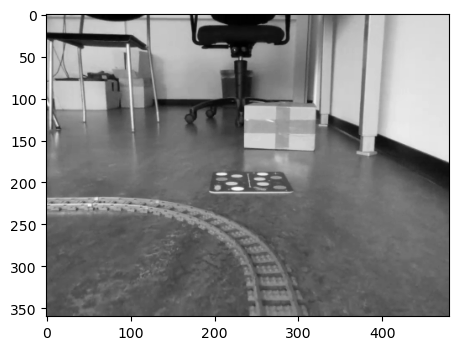

Drone Image with added Gaussian Noise:
(360, 480)


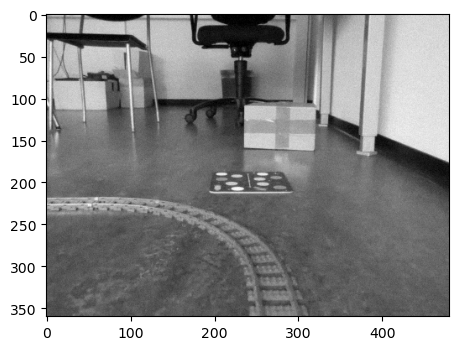

In [4]:
# Simulated Image

print("Simulated Image:")
img_path = image_paths[0]

img_sim = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

print(img_sim.shape)
plt.imshow(img_sim, cmap="gray")
plt.show()

#----------------------------------------------

# Simulated Image with Gaussian Noise

print("Simulated Image with Gaussian Noise:")

img_path = image_paths[0]

img_sim_noisy = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# https://stackoverflow.com/questions/43699326/how-to-add-gaussian-noise-in-an-image-in-python-using-pymorph/43702263
mean = 0.0
std = 5.0
img_sim_noisy = img_sim_noisy + np.random.normal(mean, std, img_sim_noisy.shape)
img_sim_noisy = np.clip(img_sim_noisy, 0, 255)  # prevent getting out of bounds due to noise


print(img_sim_noisy.shape)
plt.imshow(img_sim_noisy, cmap="gray")
plt.show()

#----------------------------------------------

# Drone Image

print("Drone Image:")

img_path = image_paths[2]

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

#percent by which the image is resized
scale_percent = 50

#calculate the 50 percent of original dimensions
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
img = cv2.resize(img, dsize)

print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

#----------------------------------------------

# Drone Image with Gaussian Noise

print("Drone Image with added Gaussian Noise:")

img_path = image_paths[2]

img_noisy = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

#percent by which the image is resized
scale_percent = 50

#calculate the 50 percent of original dimensions
width = int(img_noisy.shape[1] * scale_percent / 100)
height = int(img_noisy.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
img_noisy = cv2.resize(img_noisy, dsize)

# https://stackoverflow.com/questions/43699326/how-to-add-gaussian-noise-in-an-image-in-python-using-pymorph/43702263
mean = 0.0
std = 5.0
img_noisy = img_noisy + np.random.normal(mean, std, img_noisy.shape)
img_noisy = np.clip(img_noisy, 0, 255)  # prevent getting out of bounds due to noise

print(img_noisy.shape)
plt.imshow(img_noisy, cmap="gray")
plt.show()

# Apply Hough Transform to Simulated Image
- Validate the noise calculation in the hough transform by checking calculated image noise for the simulated image with explicitly added gaussian noise.

Simulated Image:


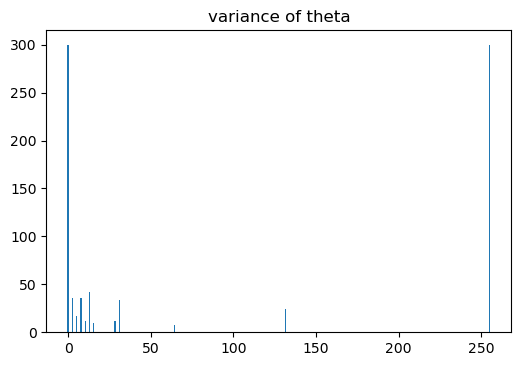

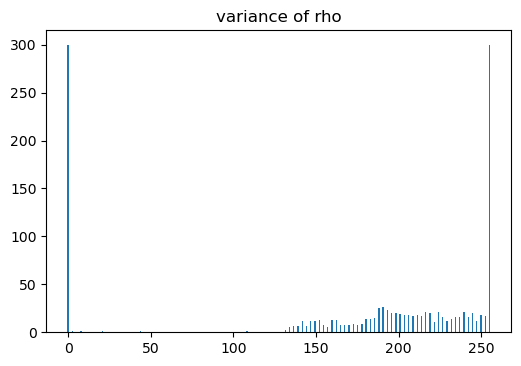

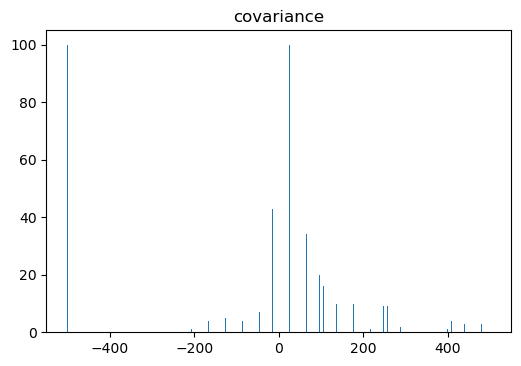

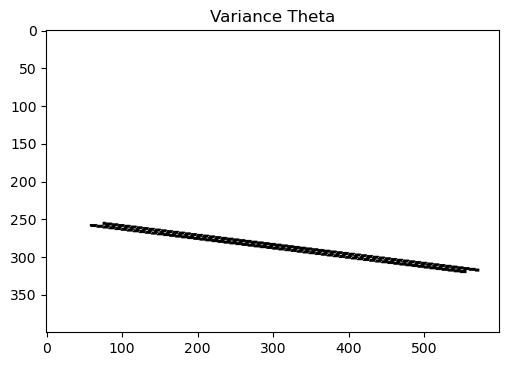

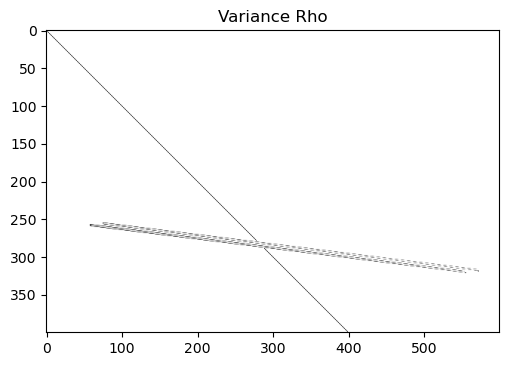

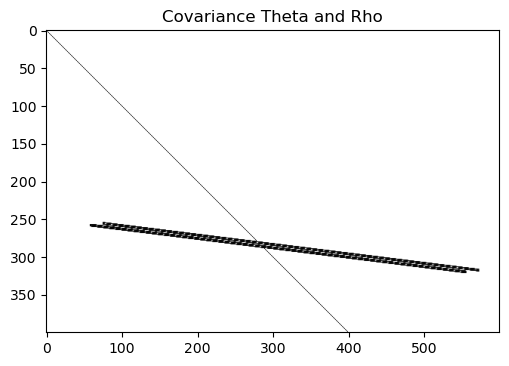

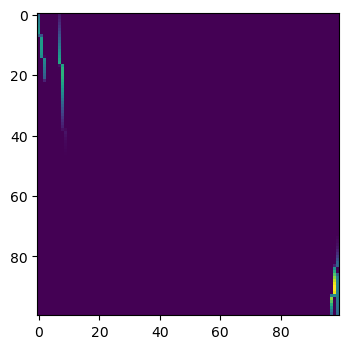


Noise Std: 43.57609226190648
---------------------------------------

Simulated Image with Gaussian Noise:


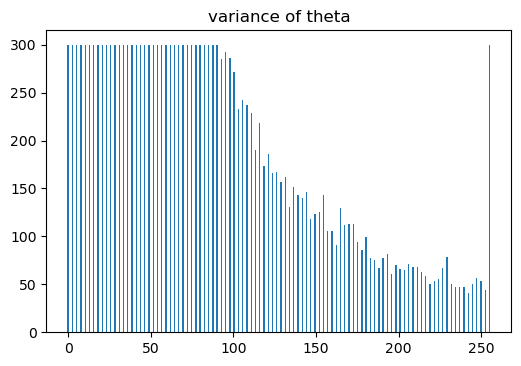

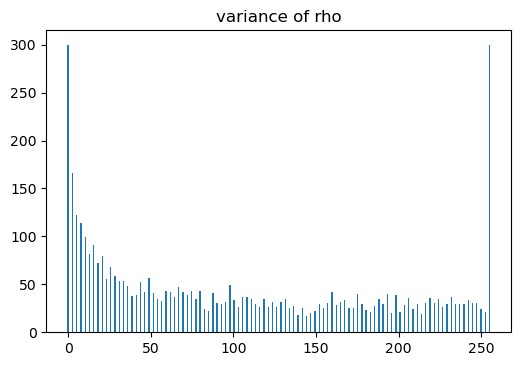

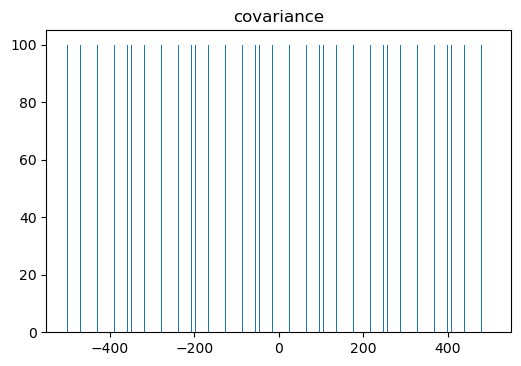

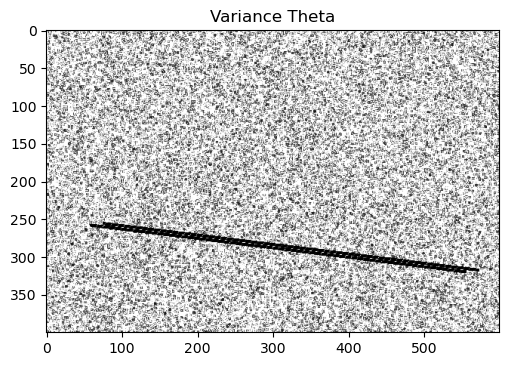

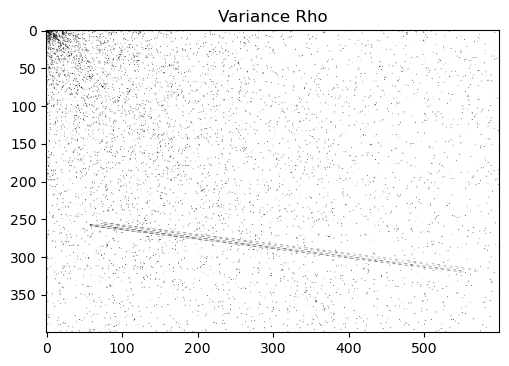

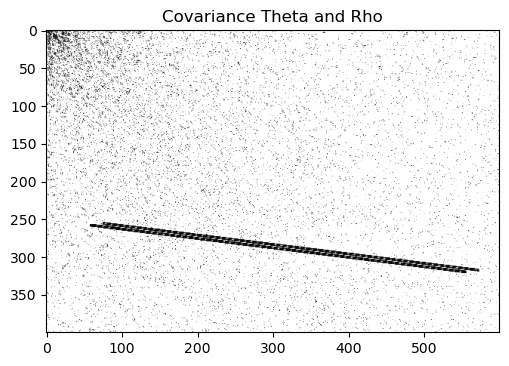

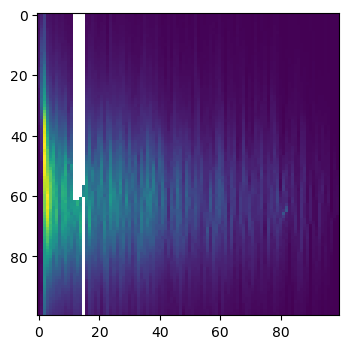


Noise Std: 57.072756005246994


In [6]:
print("Simulated Image:")
hough_sim = Hough_Transform(input_dim=(400,600))
acc_space_sim, noise_var_sim = hough_sim.forward(img_sim, visualize=True)
print("\nNoise Std:", noise_var_sim)
print("---------------------------------------\n")

print("Simulated Image with Gaussian Noise:")
hough_sim_noisy = Hough_Transform(input_dim=(400,600))
acc_space_sim_noisy, noise_var_sim_noisy = hough_sim_noisy.forward(img_sim_noisy, visualize=True)
print("\nNoise Std:", noise_var_sim_noisy)

# Apply Hough Transform to Drone Image

Drone Image:


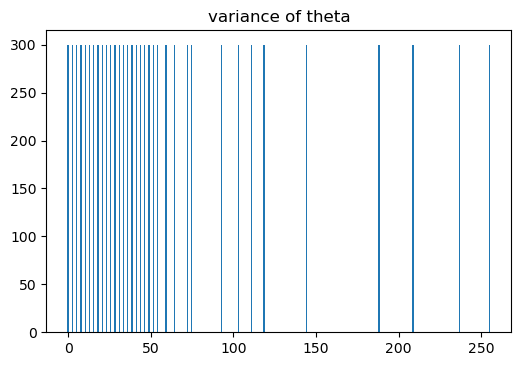

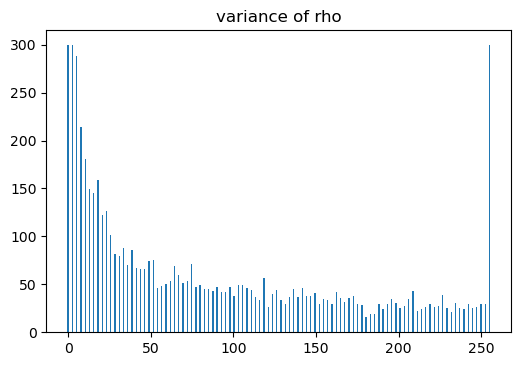

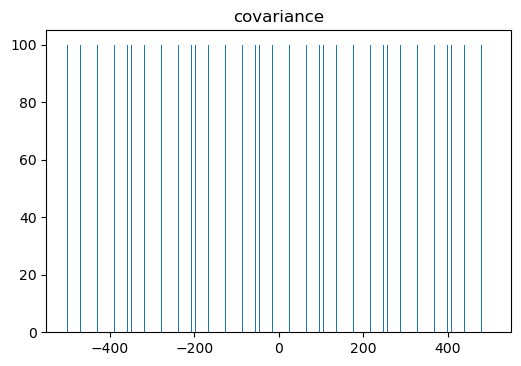

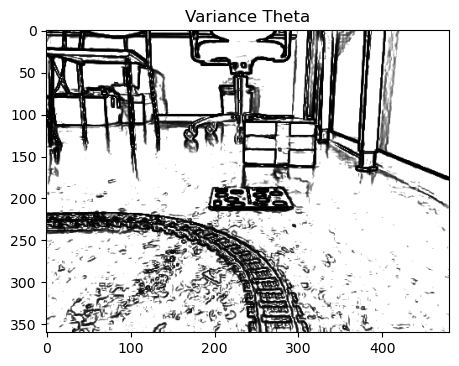

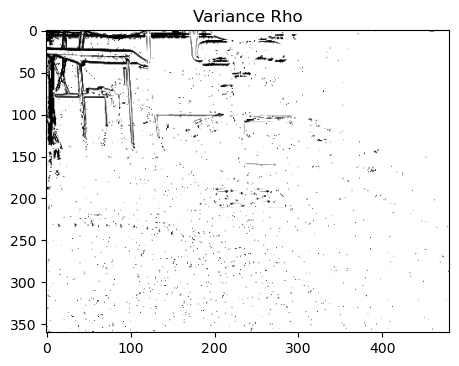

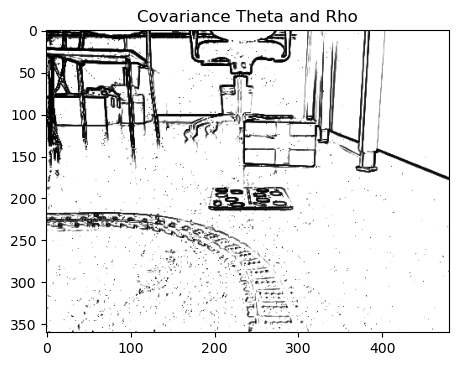

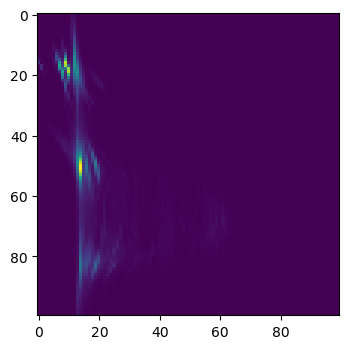


Noise Std: 313.4205235127005
---------------------------------------

Drone Image with Gaussian Noise:


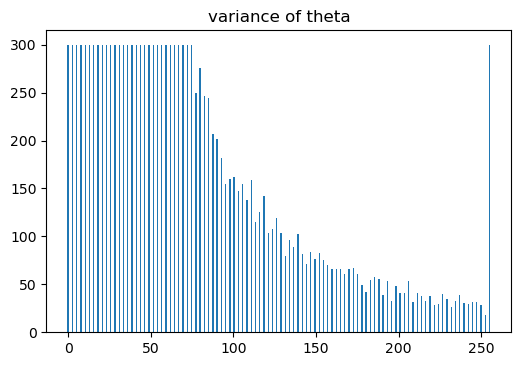

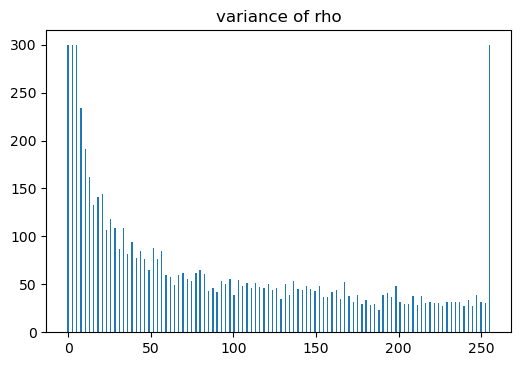

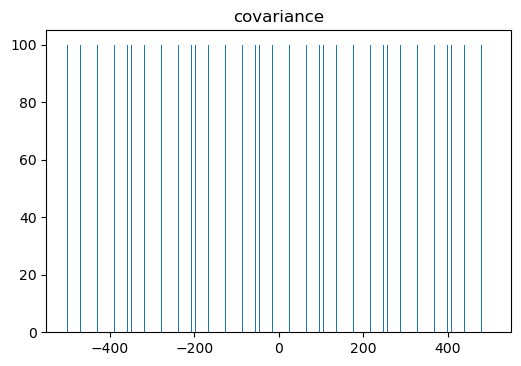

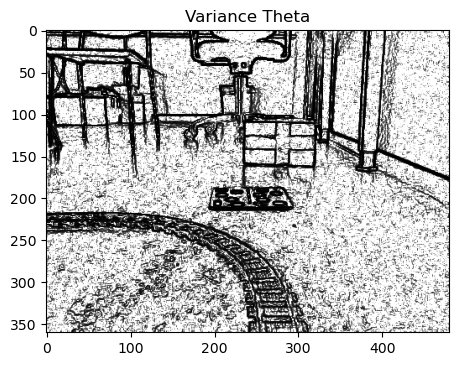

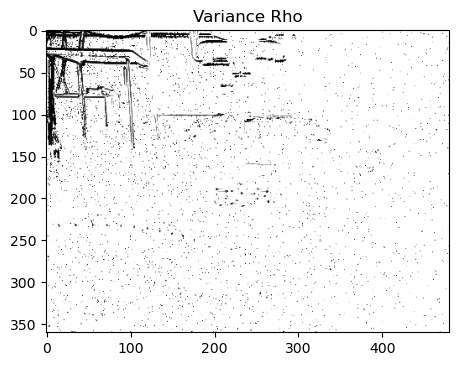

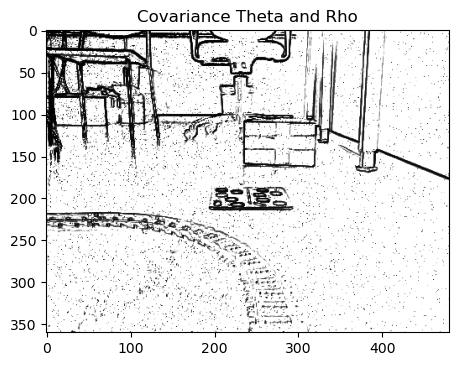

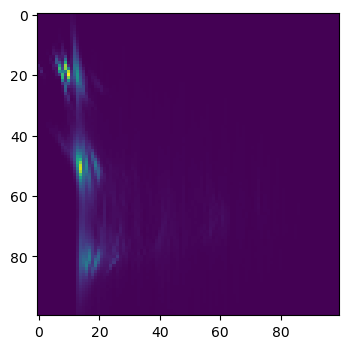


Noise Std: 355.3480638123583


In [6]:
print("Drone Image:")
hough = Hough_Transform(input_dim=(360,480))
acc_space, noise_var = hough.forward(img, visualize=True)
print("\nNoise Std:", noise_var)
print("---------------------------------------\n")

print("Drone Image with Gaussian Noise:")
hough_noisy = Hough_Transform(input_dim=(360,480))
acc_space_noisy, noise_var_noisy = hough_noisy.forward(img_noisy, visualize=True)
print("\nNoise Std:", noise_var_noisy)

In [119]:
print(acc_space.values[82][15])

#y = -xcotθ + pcosecθ

tensor(57.6621)


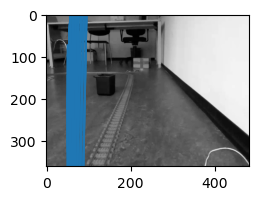

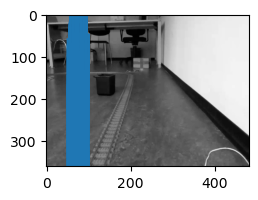

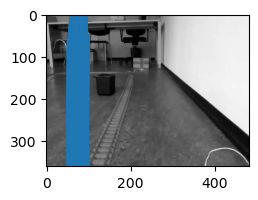

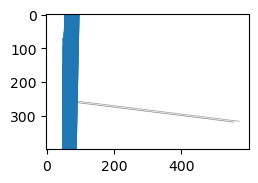

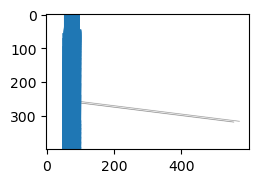

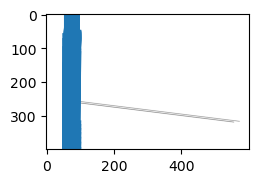

In [120]:
# Source: https://web.archive.org/web/20130617222808/http://www.aishack.in/2010/03/converting-lines-from-normal-to-slope-intercept-form/

for image in [img, img_sim]:

    for t_count in [2, 0.7, 0.9]:
        figure = plt.figure(figsize=(12, 12))
        subplot4 = figure.add_subplot(1, 4, 4)
        subplot4.imshow(image, cmap="gray")

        #t_count = 0.9
        for x in range(acc_space.values.shape[0]):
            for y in range(acc_space.values.shape[1]):
              #print(acc_space.values[y][x])
              if acc_space.values[y][x] > t_count:
                rho = acc_space.get_value_rho(x)
                rho_rad = np.deg2rad(rho)
                #print(y)
                theta = acc_space.get_value_theta(y)
                theta_rad = np.deg2rad(theta)
                #a = #np.cos(theta)

                #m = -cot(theta)
                #c = p*cosec(theta)

                m = -(np.cos(theta_rad) / np.sin(theta_rad))
                #b = #np.sin(theta)
                c = rho * (1/np.sin(theta_rad))

                x1 = 50
                y1 = m*x1 + c

                x2 = 100
                y2 = m*x2 + c

                #x0 = (a * rho) + 32
                #y0 = (b * rho) + 32
                #x1 = int(x0 + 1000 * (-b))
                #y1 = int(y0 + 1000 * (a))
                #x2 = int(x0 - 1000 * (-b))
                #y2 = int(y0 - 1000 * (a))
                #subplot3.plot([theta], [rho], marker='o', color="yellow")
                subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))
        

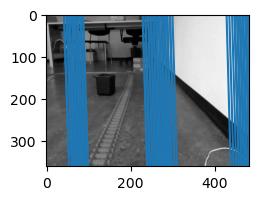

In [108]:
figure = plt.figure(figsize=(12, 12))
subplot4 = figure.add_subplot(1, 4, 4)
subplot4.imshow(img, cmap="gray")

t_count = 5
for y in range(acc_space.values.shape[0]):
    for x in range(acc_space.values.shape[1]):
      #print(acc_space.values[y][x])
      if acc_space.values[y][x] > t_count:
        rho = acc_space.get_value_rho(y)
        #print(y)
        theta = acc_space.get_value_theta(x)
        #a = #np.cos(theta)
        a = np.cos(np.deg2rad(theta))
        #b = #np.sin(theta)
        b= np.sin(np.deg2rad(theta))
        x0 = (a * rho) + 32
        y0 = (b * rho) + 32
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        #subplot3.plot([theta], [rho], marker='o', color="yellow")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

The implementation of the hough space with uncertainties shows plausible variance images (except for one diagonal line in the variance of rho for the simulated image), but the plotting of the lines is very hard to interpret and does not display the lines in the images well, neither on the simulated image, nor on the drone image.
This is why I implemented an alternative manual hough transform without uncertainties to play with the thresholds that optimally detect the rails.

# Count of detected lines for different thresholds

Drone Image:


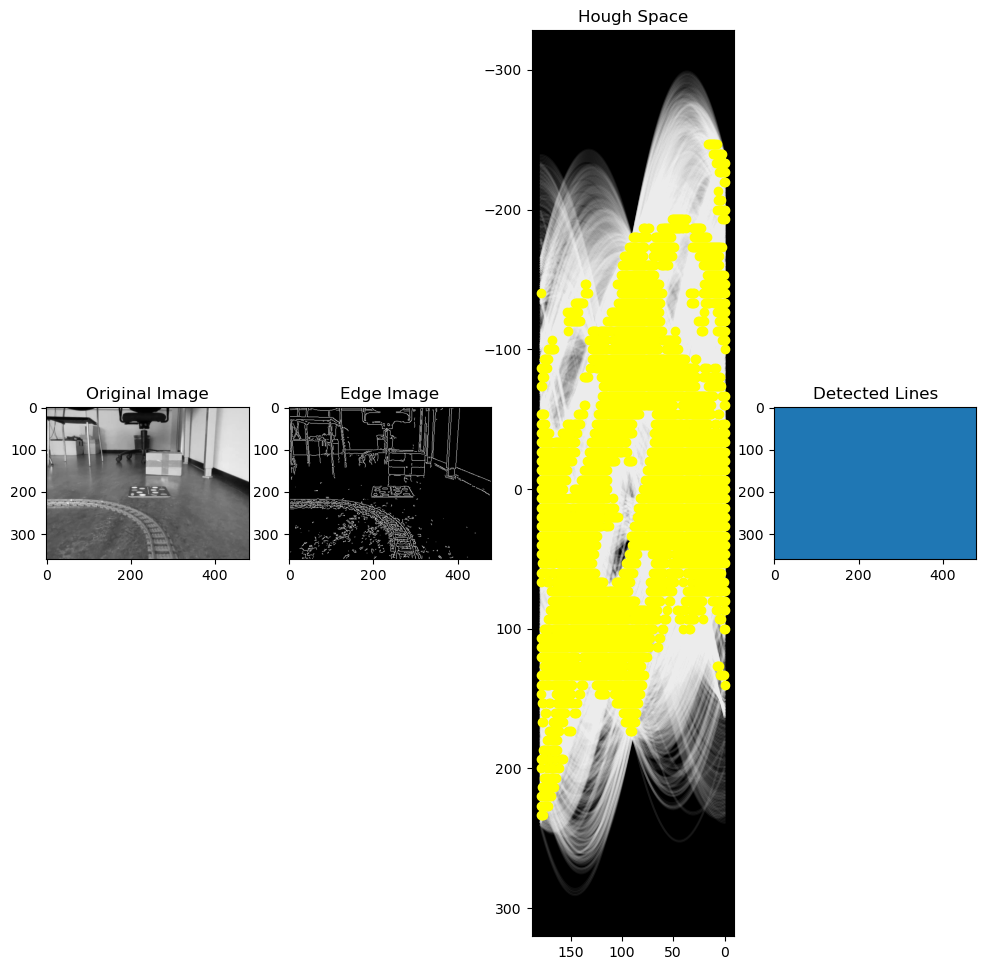

Number of lines for the threshold: 5539


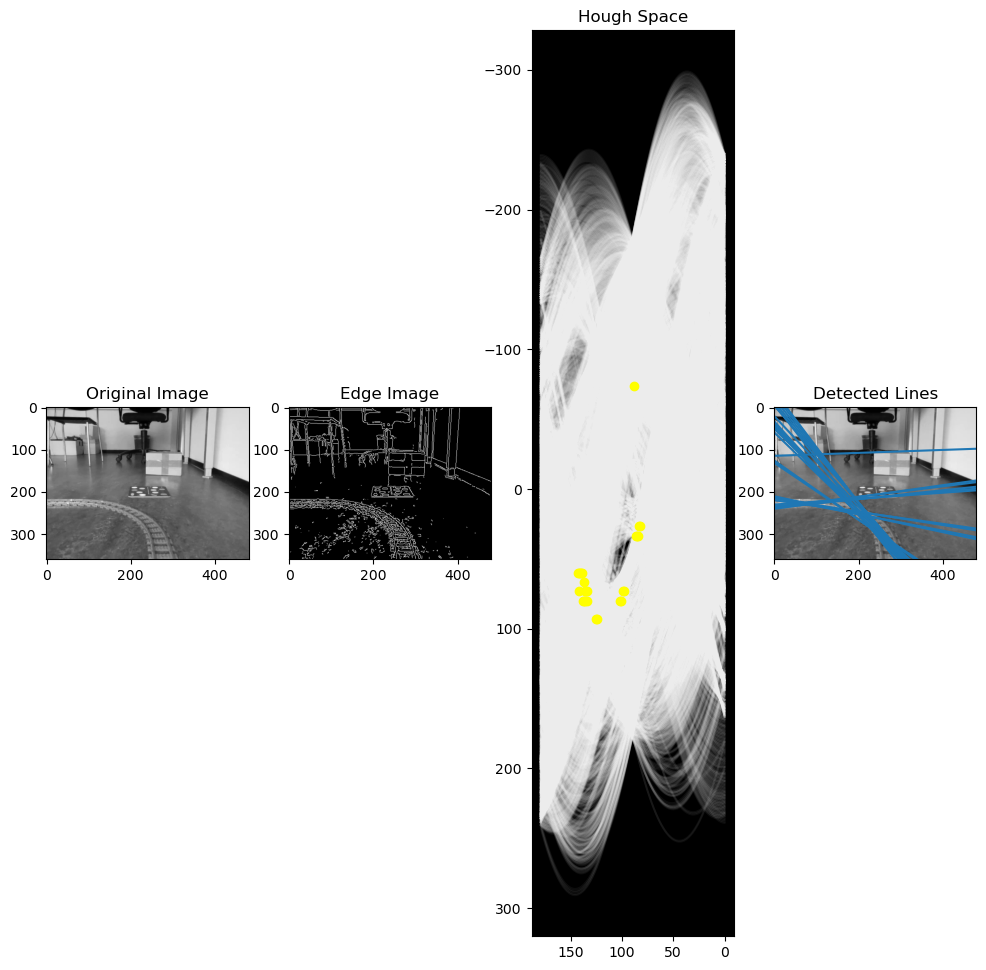

Number of lines for the threshold: 26


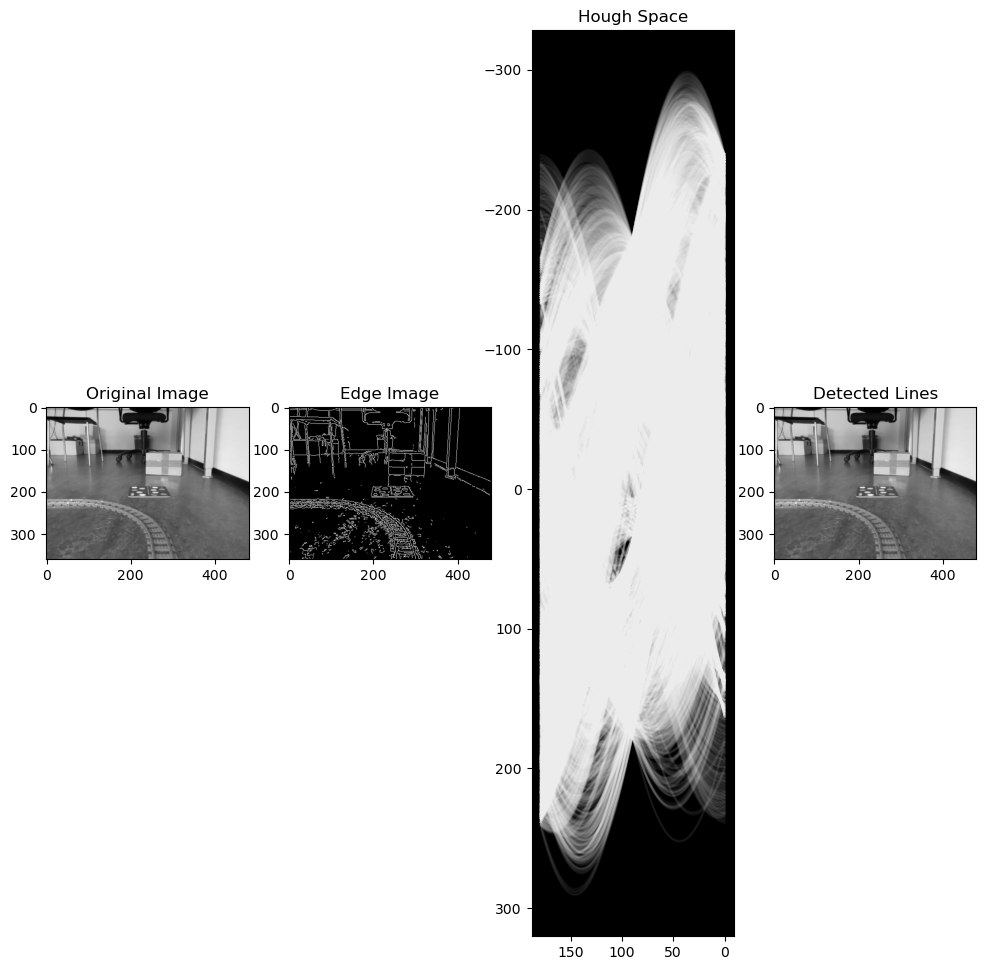

Number of lines for the threshold: 0


In [5]:
#Source: https://towardsdatascience.com/lines-detection-with-hough-transform-84020b3b1549

def line_detection_non_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=80):
    count = 0
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    #
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    #
    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
    #
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    #
    accumulator = np.zeros((len(rhos), len(rhos)))
    #
    figure = plt.figure(figsize=(12, 12))
    subplot1 = figure.add_subplot(1, 4, 1)
    subplot1.imshow(image, cmap="gray")
    subplot2 = figure.add_subplot(1, 4, 2)
    subplot2.imshow(edge_image, cmap="gray")
    subplot3 = figure.add_subplot(1, 4, 3)
    subplot3.set_facecolor((0, 0, 0))
    subplot4 = figure.add_subplot(1, 4, 4)
    subplot4.imshow(image, cmap="gray")
    #
    for y in range(edge_height):
        for x in range(edge_width):
            if edge_image[y][x] != 0:
                edge_point = [y - edge_height_half, x - edge_width_half]
                ys, xs = [], []
                for theta_idx in range(len(thetas)):
                    rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
                    theta = thetas[theta_idx]
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    accumulator[rho_idx][theta_idx] += 1
                    ys.append(rho)
                    xs.append(theta)
                subplot3.plot(xs, ys, color="white", alpha=0.05)

    for y in range(accumulator.shape[0]):
        for x in range(accumulator.shape[1]):
            if accumulator[y][x] > t_count:
                count += 1
                rho = rhos[y]
                theta = thetas[x]
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                x0 = (a * rho) + edge_width_half
                y0 = (b * rho) + edge_height_half
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                subplot3.plot([theta], [rho], marker='o', color="yellow")
                subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

    subplot3.invert_yaxis()
    subplot3.invert_xaxis()

    subplot1.title.set_text("Original Image")
    subplot2.title.set_text("Edge Image")
    subplot3.title.set_text("Hough Space")
    subplot4.title.set_text("Detected Lines")
    plt.show()
    print("Number of lines for the threshold:", count)
    return accumulator, rhos, thetas


print("Drone Image:")
for t_count in [200,500,615]:
    edge_image = cv2.Canny(img, 60, 70)
    line_detection_non_vectorized(img, edge_image, t_count=t_count)
    
#print("Simulated Image:")
#for t_count in [50,250,700]:
#    edge_image = cv2.Canny(img_sim, 100, 200)
#    line_detection_non_vectorized(img_sim, edge_image, t_count=t_count)

I chose a simulated and a drone image with straight rails for testing.
I tried different thresholds, and with some manual optimizing of the threshold values (615 for the drone image and 700 for the simulated image worked best for me), the detected lines focus fairly well on the rails.

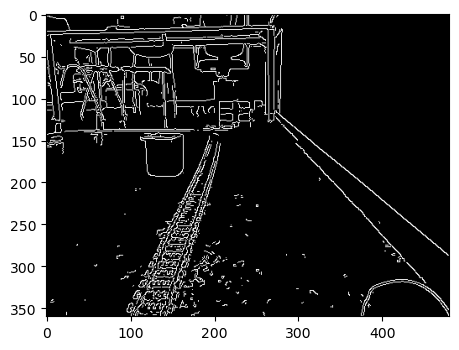

In [106]:
# test parameters for canny edge detection

edge_image = cv2.Canny(img, 60, 70)
plt.imshow(edge_image, cmap="gray")